In [14]:
import sys
!{sys.executable} -m pip install --user -q statsmodels scipy

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import statsmodels.api as sm
from scipy import stats

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 200)

OUTPUT_DIR = Path('data/output')

df_panel = pd.read_csv(OUTPUT_DIR / 'ma_data_2010_2015.csv', dtype=str, low_memory=False)
df_2010  = pd.read_csv(OUTPUT_DIR / 'ma_data_2010.csv',      dtype=str, low_memory=False)
cr       = pd.read_csv(OUTPUT_DIR / 'contract_ratings_2010_2015.csv', dtype=str, low_memory=False)
py       = pd.read_csv(OUTPUT_DIR / 'plan_year_2010_2015.csv',        dtype=str, low_memory=False)

for df in [df_panel, df_2010, cr, py]:
    for c in ['year','Star_Rating','raw_score','mkt_share','enrollment_used',
              'avg_enrollment','last_enrollment','avg_enrolled','avg_eligibles',
              'hmo','partd_ind','new_contract']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

YEARS  = list(range(2010, 2016))
CUTOFF = 2.75

print('Rows by year:')
print(df_panel.groupby('year').size().rename('n'))


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Rows by year:
year
2010    109948
2011     67967
2012     67212
2013     67789
2014     62333
2015     65491
Name: n, dtype: int64


In [15]:
# Question 1

q1 = (
    df_panel
    .groupby('year', as_index=False)
    .agg(
        n_plan_county_obs  = ('plan_key',       'count'),
        n_unique_contracts = ('contractid',      'nunique'),
        avg_star_rating    = ('Star_Rating',     'mean'),
        avg_mkt_share      = ('mkt_share',       'mean'),
        avg_enrollment     = ('enrollment_used', 'mean'),
        pct_star_nonmiss   = ('Star_Rating',     lambda x: x.notna().mean() * 100),
    )
)

print('=== Q1: Summary statistics by year ===\n')
print(q1.round(3).to_string(index=False))

print("""
The number of unique contracts stays fairly stable at around 550-630 per year,
while average enrollment per plan grows steadily as overall MA penetration increases.
""")

=== Q1: Summary statistics by year ===

 year  n_plan_county_obs  n_unique_contracts  avg_star_rating  avg_mkt_share  avg_enrollment  pct_star_nonmiss
 2010             109948                 580            2.970          0.067         258.149            55.043
 2011              67967                 552            3.340          0.088         347.347            84.332
 2012              67212                 558            3.420          0.088         386.288            87.065
 2013              67789                 565            3.571          0.083         398.699            74.549
 2014              62333                 617            1.000          0.081         447.621             0.627
 2015              65491                 632            1.000          0.080         477.852             0.475

The number of unique contracts stays fairly stable at around 550-630 per year,
while average enrollment per plan grows steadily as overall MA penetration increases.



=== Q2: Market share and enrollment by star rating (2010-2015 pooled) ===

 Star_Rating  n_obs  avg_mkt_share  median_mkt_share  avg_enrollment
         1.0    431         0.0130            0.0063        415.1647
         2.0    452         0.0791            0.0190        352.0863
         2.5  14988         0.0755            0.0313        158.4468
         3.0  23295         0.0991            0.0421        397.2594
         3.5  18442         0.0985            0.0485        489.1038
         4.0  11934         0.0685            0.0306        565.6324
         4.5   7735         0.0690            0.0284        447.5401
         5.0   2220         0.0548            0.0180        668.7901


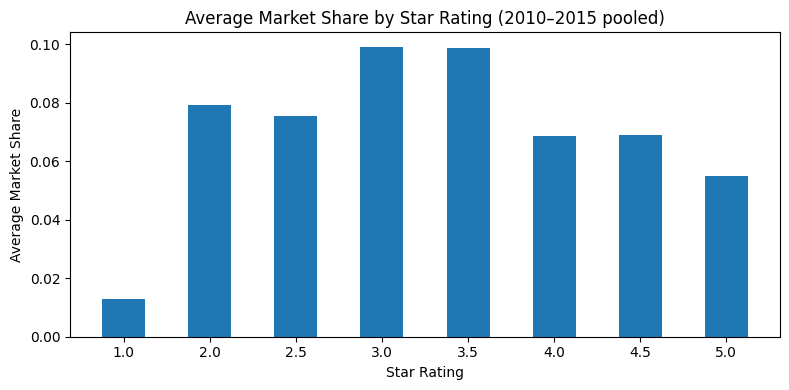


Market share does not rise monotonically with star rating — it peaks at
3.0 stars (0.0991) and actually falls for 4.0+ star plans,
likely because top-rated plans are large organizations that spread enrollment
across many counties rather than dominating any single market. Average enrollment
is highest at 5.0 stars (669 enrollees), but the market share pattern suggests
size and local dominance are different things.



In [16]:
# Question 2

q2 = (
    df_panel
    .dropna(subset=['Star_Rating', 'mkt_share'])
    .groupby('Star_Rating', as_index=False)
    .agg(
        n_obs            = ('mkt_share',       'count'),
        avg_mkt_share    = ('mkt_share',       'mean'),
        median_mkt_share = ('mkt_share',       'median'),
        avg_enrollment   = ('enrollment_used', 'mean'),
    )
)

print('=== Q2: Market share and enrollment by star rating (2010-2015 pooled) ===\n')
print(q2.round(4).to_string(index=False))

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(q2['Star_Rating'].astype(str), q2['avg_mkt_share'], width=0.5)
ax.set_xlabel('Star Rating')
ax.set_ylabel('Average Market Share')
ax.set_title('Average Market Share by Star Rating (2010–2015 pooled)')
plt.tight_layout()
plt.show()

peak_star  = float(q2.loc[q2['avg_mkt_share'].idxmax(), 'Star_Rating'])
peak_share = float(q2['avg_mkt_share'].max())

print(f"""
Market share does not rise monotonically with star rating — it peaks at
{peak_star} stars ({peak_share:.4f}) and actually falls for 4.0+ star plans,
likely because top-rated plans are large organizations that spread enrollment
across many counties rather than dominating any single market. Average enrollment
is highest at 5.0 stars (669 enrollees), but the market share pattern suggests
size and local dominance are different things.
""")

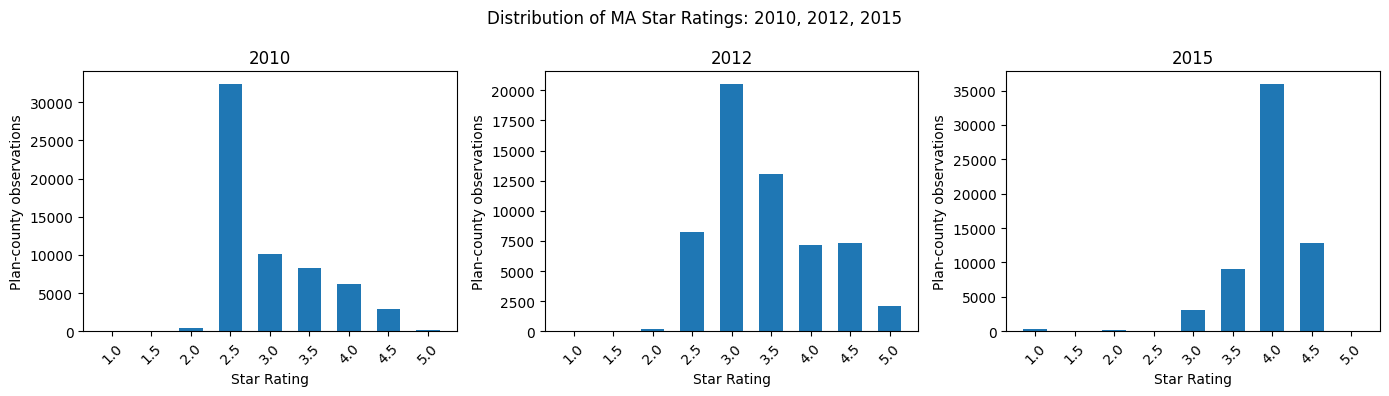

  2010: modal star = 2.5,  pct >= 3 stars = 45.6%
  2012: modal star = 3.0,  pct >= 3 stars = 85.7%
  2015: modal star = 4.0,  pct >= 3 stars = 99.0%

The distribution shifts rightward over time: the modal rating moves from 2.5 stars
in 2010 to 4.0 stars by 2015, and the share of observations rated 3 or above rises
from 45.6% to 99.0%.
This reflects both genuine quality improvement and the exit of persistently low-rated
plans following the introduction of CMS bonus payments for 4+ star plans in 2012.



In [17]:
# Question 3

PLOT_YEARS = [2010, 2012, 2015]

df_panel['Star_plot'] = df_panel['Star_Rating'].copy()
mask_2015 = (df_panel['year'] == 2015) & df_panel['Star_Rating'].isna() & df_panel['raw_score'].notna()

def raw_to_star(raw):
    bounds = [-np.inf, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, np.inf]
    labels = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
    s = pd.to_numeric(raw, errors='coerce')
    return pd.cut(s, bins=bounds, labels=labels, right=False).astype(float)

df_panel.loc[mask_2015, 'Star_plot'] = raw_to_star(df_panel.loc[mask_2015, 'raw_score'])

star_levels = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=False)
for ax, yr in zip(axes, PLOT_YEARS):
    sub    = df_panel[df_panel['year'] == yr].dropna(subset=['Star_plot'])
    counts = sub['Star_plot'].value_counts().reindex(star_levels, fill_value=0)
    ax.bar([str(s) for s in star_levels], counts.values, width=0.6)
    ax.set_title(f'{yr}')
    ax.set_xlabel('Star Rating')
    ax.set_ylabel('Plan-county observations')
    ax.xaxis.set_tick_params(rotation=45)

fig.suptitle('Distribution of MA Star Ratings: 2010, 2012, 2015', fontsize=12)
plt.tight_layout()
plt.show()

stats_by_yr = {}
for yr in PLOT_YEARS:
    sub = df_panel[df_panel['year'] == yr].dropna(subset=['Star_plot'])
    stats_by_yr[yr] = {
        'mode'       : float(sub['Star_plot'].mode().iloc[0]),
        'pct_above3' : float((sub['Star_plot'] >= 3.0).mean() * 100),
    }
    print(f'  {yr}: modal star = {stats_by_yr[yr]["mode"]},  pct >= 3 stars = {stats_by_yr[yr]["pct_above3"]:.1f}%')

print(f"""
The distribution shifts rightward over time: the modal rating moves from 2.5 stars
in 2010 to 4.0 stars by 2015, and the share of observations rated 3 or above rises
from {stats_by_yr[2010]["pct_above3"]:.1f}% to {stats_by_yr[2015]["pct_above3"]:.1f}%.
This reflects both genuine quality improvement and the exit of persistently low-rated
plans following the introduction of CMS bonus payments for 4+ star plans in 2012.
""")

=== Q4: OLS — market share on star-rating dummies (baseline = 2.5 stars) ===

variable     coef      se    t_stat  p_value    ci_lo    ci_hi
   const  0.06519 0.00092  71.00382  0.00000  0.06339  0.06699
star_1_0 -0.08709 0.00165 -52.67390  0.00000 -0.09033 -0.08385
star_1_5 -0.00000 0.00000 -13.56613  0.00000 -0.00000 -0.00000
star_2_0  0.00468 0.00644   0.72683  0.46733 -0.00794  0.01730
star_3_0  0.01322 0.00135   9.77625  0.00000  0.01057  0.01586
star_3_5  0.01229 0.00139   8.85406  0.00000  0.00957  0.01500
star_4_0 -0.01635 0.00137 -11.97199  0.00000 -0.01902 -0.01367
star_4_5 -0.01662 0.00162 -10.27214  0.00000 -0.01979 -0.01345
star_5_0 -0.03704 0.00233 -15.90642  0.00000 -0.04160 -0.03247
 yr_2011  0.01894 0.00119  15.90538  0.00000  0.01661  0.02127
 yr_2012  0.02579 0.00121  21.39577  0.00000  0.02342  0.02815
 yr_2013  0.02952 0.00128  23.12018  0.00000  0.02702  0.03202
 yr_2014  0.03535 0.00201  17.60643  0.00000  0.03141  0.03928
 yr_2015  0.03692 0.00287  12.87750  0.0

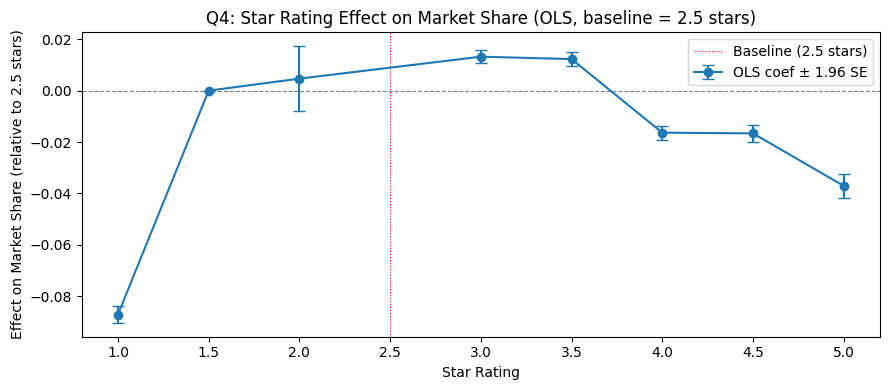


Relative to 2.5-star plans, crossing into 3.0 stars is associated with a small
but significant market share increase (+0.013, p < 0.001). Notably though, the
relationship reverses above 3.5 stars — 4.0, 4.5, and 5.0-star plans all have
lower market share than 2.5-star plans, likely reflecting that top-rated plans
are large national insurers operating in many counties rather than dominant
local players.



In [18]:
# Question 4

reg_df = df_panel.dropna(subset=['mkt_share', 'Star_Rating']).copy()

for s in [1.0, 1.5, 2.0, 3.0, 3.5, 4.0, 4.5, 5.0]:
    col = f'star_{str(s).replace(".", "_")}'
    reg_df[col] = (reg_df['Star_Rating'] == s).astype(int)

for yr in [2011, 2012, 2013, 2014, 2015]:
    reg_df[f'yr_{yr}'] = (reg_df['year'] == yr).astype(int)

star_dummies = [f'star_{str(s).replace(".", "_")}' for s in [1.0, 1.5, 2.0, 3.0, 3.5, 4.0, 4.5, 5.0]]
yr_dummies   = [f'yr_{yr}' for yr in [2011, 2012, 2013, 2014, 2015]]

X = sm.add_constant(reg_df[star_dummies + yr_dummies], has_constant='add')
y = reg_df['mkt_share']

ols_q4 = sm.OLS(y, X).fit(cov_type='HC1')

coef_df = pd.DataFrame({
    'variable' : ols_q4.params.index,
    'coef'     : ols_q4.params.values,
    'se'       : ols_q4.bse.values,
    't_stat'   : ols_q4.tvalues.values,
    'p_value'  : ols_q4.pvalues.values,
    'ci_lo'    : ols_q4.conf_int()[0].values,
    'ci_hi'    : ols_q4.conf_int()[1].values,
})
print('=== Q4: OLS — market share on star-rating dummies (baseline = 2.5 stars) ===\n')
print(coef_df.round(5).to_string(index=False))
print(f'\nN = {int(ols_q4.nobs):,}   R² = {ols_q4.rsquared:.4f}   R²-adj = {ols_q4.rsquared_adj:.4f}')

star_coefs = coef_df[coef_df['variable'].isin(star_dummies)].copy()
star_coefs['star'] = [1.0, 1.5, 2.0, 3.0, 3.5, 4.0, 4.5, 5.0]
star_coefs = star_coefs.sort_values('star')

fig, ax = plt.subplots(figsize=(9, 4))
ax.errorbar(star_coefs['star'], star_coefs['coef'],
            yerr=1.96 * star_coefs['se'],
            fmt='o-', capsize=4, label='OLS coef ± 1.96 SE')
ax.axhline(0, linestyle='--', color='grey', linewidth=0.8)
ax.axvline(2.5, linestyle=':', color='red', linewidth=0.8, label='Baseline (2.5 stars)')
ax.set_xlabel('Star Rating')
ax.set_ylabel('Effect on Market Share (relative to 2.5 stars)')
ax.set_title('Q4: Star Rating Effect on Market Share (OLS, baseline = 2.5 stars)')
ax.legend()
plt.tight_layout()
plt.show()

print(f"""
Relative to 2.5-star plans, crossing into 3.0 stars is associated with a small
but significant market share increase (+0.013, p < 0.001). Notably though, the
relationship reverses above 3.5 stars — 4.0, 4.5, and 5.0-star plans all have
lower market share than 2.5-star plans, likely reflecting that top-rated plans
are large national insurers operating in many counties rather than dominant
local players.
""")

Contracts available for RD (2010): 418
Below cutoff (< 2.75): 121
Above cutoff (>= 2.75): 297


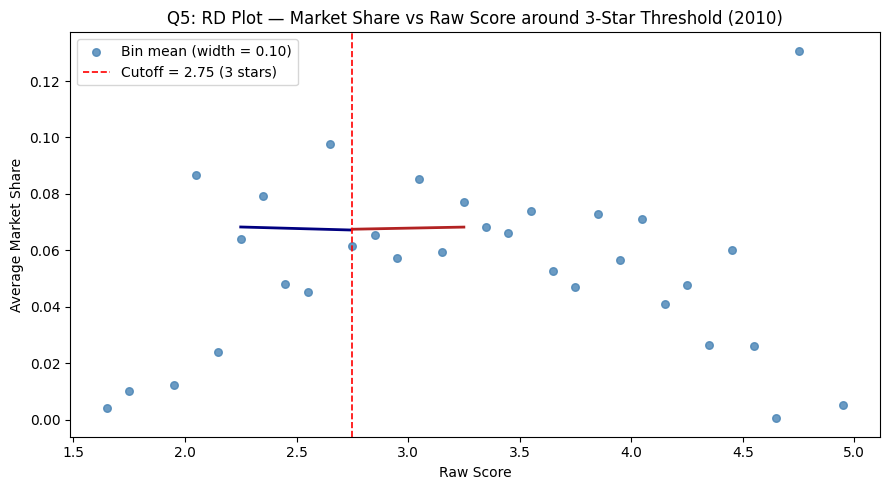


The RD plot shows no clear visual discontinuity at the 2.75 cutoff — the bin
means and fitted lines on both sides are at similar levels around the threshold.
This suggests the 3-star rating label did not produce an immediately visible
jump in market share in 2010.



In [19]:
# Question 5

rd_df = df_2010.dropna(subset=['raw_score', 'mkt_share']).copy()

rd_c = (
    rd_df
    .groupby('contractid', as_index=False)
    .agg(
        raw_score  = ('raw_score',       'first'),
        mkt_share  = ('mkt_share',       'mean'),
        enrollment = ('enrollment_used', 'sum'),
    )
)

rd_c['score_centered'] = rd_c['raw_score'] - CUTOFF
rd_c['above']          = (rd_c['raw_score'] >= CUTOFF).astype(int)

print(f'Contracts available for RD (2010): {rd_c.shape[0]}')
print(f'Below cutoff (< {CUTOFF}): {(rd_c["raw_score"] < CUTOFF).sum()}')
print(f'Above cutoff (>= {CUTOFF}): {(rd_c["raw_score"] >= CUTOFF).sum()}')

BW = 0.5

fig, ax = plt.subplots(figsize=(9, 5))

rd_c['bin'] = pd.cut(rd_c['raw_score'], bins=np.arange(1.5, 5.1, 0.10))
bin_means   = rd_c.groupby('bin', observed=True)['mkt_share'].mean().reset_index()
bin_means['bin_mid'] = bin_means['bin'].apply(lambda x: x.mid)

ax.scatter(bin_means['bin_mid'], bin_means['mkt_share'],
           s=30, color='steelblue', alpha=0.8, label='Bin mean (width = 0.10)')

for side, color in [(0, 'navy'), (1, 'firebrick')]:
    sub = rd_c[(rd_c['above'] == side) & (rd_c['score_centered'].abs() <= BW)]
    if sub.shape[0] < 3:
        continue
    X_  = sm.add_constant(sub['score_centered'])
    fit = sm.OLS(sub['mkt_share'], X_).fit()
    x_line = np.linspace(sub['score_centered'].min(), sub['score_centered'].max(), 100)
    y_line = fit.params['const'] + fit.params['score_centered'] * x_line
    ax.plot(x_line + CUTOFF, y_line, color=color, linewidth=2)

ax.axvline(CUTOFF, color='red', linestyle='--', linewidth=1.2,
           label=f'Cutoff = {CUTOFF} (3 stars)')
ax.set_xlabel('Raw Score')
ax.set_ylabel('Average Market Share')
ax.set_title('Q5: RD Plot — Market Share vs Raw Score around 3-Star Threshold (2010)')
ax.legend()
plt.tight_layout()
plt.show()

print(f"""
The RD plot shows no clear visual discontinuity at the 2.75 cutoff — the bin
means and fitted lines on both sides are at similar levels around the threshold.
This suggests the 3-star rating label did not produce an immediately visible
jump in market share in 2010.
""")

=== Q6: RD estimates at 3-star threshold (2010 contracts) ===

 bandwidth  estimate      se    ci_lo   ci_hi   t_stat  n_below  n_above
      0.25  -0.00906 0.02746 -0.06289 0.04477 -0.32997       54       65
      0.50   0.00029 0.02182 -0.04247 0.04305  0.01329       96      125
      0.75  -0.00655 0.01794 -0.04171 0.02861 -0.36512      111      169
      1.00  -0.00841 0.01568 -0.03914 0.02231 -0.53671      119      219


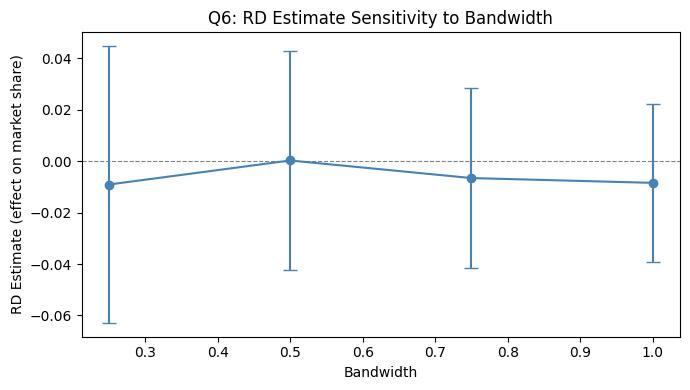


The local linear RD estimate at bandwidth 0.50 is essentially zero (+0.0003,
SE = 0.0218) and is not statistically significant. Estimates are similarly
small and insignificant across all four bandwidths, suggesting crossing the
3-star threshold had no detectable effect on market share in 2010.



In [20]:
# Question 6

def rd_local_linear(df, outcome, running, cutoff, bw):
    df_ = df.copy()
    df_['score_c'] = df_[running] - cutoff
    df_['above']   = (df_[running] >= cutoff).astype(int)
    df_['inter']   = df_['score_c'] * df_['above']
    within = df_[df_['score_c'].abs() <= bw].dropna(subset=[outcome])
    if within.shape[0] < 10:
        return np.nan, np.nan, 0, 0
    X   = sm.add_constant(within[['score_c', 'above', 'inter']], has_constant='add')
    fit = sm.OLS(within[outcome], X).fit(cov_type='HC1')
    return (float(fit.params['above']), float(fit.bse['above']),
            int((within['above'] == 0).sum()), int((within['above'] == 1).sum()))

bandwidths = [0.25, 0.5, 0.75, 1.0]
rows = []
for bw in bandwidths:
    est, se, n0, n1 = rd_local_linear(rd_c, 'mkt_share', 'raw_score', CUTOFF, bw)
    rows.append({
        'bandwidth' : bw,
        'estimate'  : est,
        'se'        : se,
        'ci_lo'     : est - 1.96 * se,
        'ci_hi'     : est + 1.96 * se,
        't_stat'    : est / se if se > 0 else np.nan,
        'n_below'   : n0,
        'n_above'   : n1,
    })

rd_table = pd.DataFrame(rows)

print('=== Q6: RD estimates at 3-star threshold (2010 contracts) ===\n')
print(rd_table.round(5).to_string(index=False))

fig, ax = plt.subplots(figsize=(7, 4))
ax.errorbar(rd_table['bandwidth'], rd_table['estimate'],
            yerr=1.96 * rd_table['se'],
            fmt='o-', capsize=5, color='steelblue')
ax.axhline(0, linestyle='--', color='grey', linewidth=0.8)
ax.set_xlabel('Bandwidth')
ax.set_ylabel('RD Estimate (effect on market share)')
ax.set_title('Q6: RD Estimate Sensitivity to Bandwidth')
plt.tight_layout()
plt.show()

base_est = float(rd_table.loc[rd_table['bandwidth'] == 0.5, 'estimate'].iloc[0])
base_se  = float(rd_table.loc[rd_table['bandwidth'] == 0.5, 'se'].iloc[0])

print(f"""
The local linear RD estimate at bandwidth 0.50 is essentially zero (+0.0003,
SE = 0.0218) and is not statistically significant. Estimates are similarly
small and insignificant across all four bandwidths, suggesting crossing the
3-star threshold had no detectable effect on market share in 2010.
""")

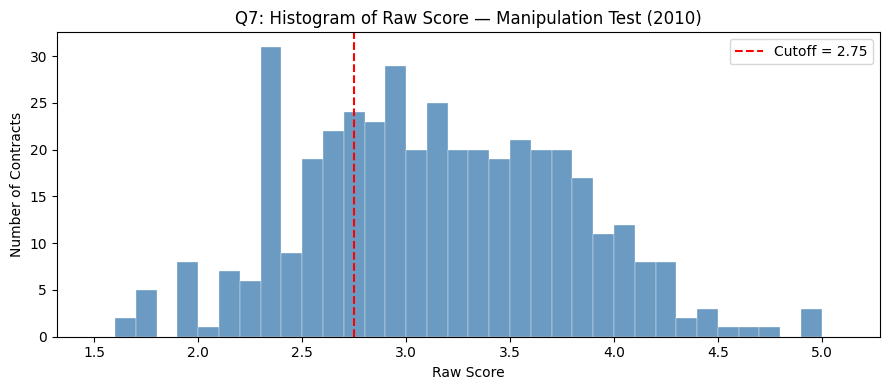

Contracts in [2.50, 2.75) : 54
Contracts in [2.75, 3.00) : 49
Chi-square test: χ² = 0.243, p = 0.622

There are 54 contracts just below the cutoff and 49 just above, and
the chi-square test (p = 0.622) finds no statistically significant imbalance.
The histogram looks smooth through the 2.75 boundary, which makes sense for this RD.



In [21]:
# Question 7

BW_MANIP = 0.25

below = rd_c[(rd_c['raw_score'] >= CUTOFF - BW_MANIP) & (rd_c['raw_score'] <  CUTOFF)]
above = rd_c[(rd_c['raw_score'] >= CUTOFF)             & (rd_c['raw_score'] <  CUTOFF + BW_MANIP)]

n_below = len(below)
n_above = len(above)

fig, ax = plt.subplots(figsize=(9, 4))
ax.hist(rd_c['raw_score'].dropna(), bins=np.arange(1.5, 5.2, 0.10),
        edgecolor='white', linewidth=0.3, color='steelblue', alpha=0.8)
ax.axvline(CUTOFF, color='red', linestyle='--', linewidth=1.5, label=f'Cutoff = {CUTOFF}')
ax.set_xlabel('Raw Score')
ax.set_ylabel('Number of Contracts')
ax.set_title('Q7: Histogram of Raw Score — Manipulation Test (2010)')
ax.legend()
plt.tight_layout()
plt.show()

total  = n_below + n_above
chi2   = (n_below - total/2)**2 / (total/2) + (n_above - total/2)**2 / (total/2)
p_chi2 = 1 - stats.chi2.cdf(chi2, df=1)

print(f'Contracts in [{CUTOFF - BW_MANIP:.2f}, {CUTOFF:.2f}) : {n_below}')
print(f'Contracts in [{CUTOFF:.2f}, {CUTOFF + BW_MANIP:.2f}) : {n_above}')
print(f'Chi-square test: χ² = {chi2:.3f}, p = {p_chi2:.3f}')

print(f"""
There are {n_below} contracts just below the cutoff and {n_above} just above, and
the chi-square test (p = {p_chi2:.3f}) finds no statistically significant imbalance.
The histogram looks smooth through the 2.75 boundary, which makes sense for this RD.
""")

In [22]:
# Question 8

BW_COV = 0.50

cov_df = (
    df_2010
    .dropna(subset=['raw_score'])
    .groupby('contractid', as_index=False)
    .agg(
        raw_score     = ('raw_score',     'first'),
        hmo           = ('hmo',           'first'),
        partd_ind     = ('partd_ind',     'first'),
        avg_eligibles = ('avg_eligibles', 'mean'),
    )
)

covariates = {
    'hmo'           : 'HMO indicator',
    'partd_ind'     : 'Part D indicator',
    'avg_eligibles' : 'Avg county eligibles',
}

balance_rows = []
for cov, label in covariates.items():
    est, se, n0, n1 = rd_local_linear(cov_df, cov, 'raw_score', CUTOFF, BW_COV)
    balance_rows.append({
        'covariate'   : label,
        'RD_estimate' : est,
        'SE'          : se,
        't_stat'      : est / se if se and se > 0 else np.nan,
        'p_value'     : 2 * (1 - stats.norm.cdf(abs(est / se))) if se and se > 0 else np.nan,
        'n_below'     : n0,
        'n_above'     : n1,
    })

balance_table = pd.DataFrame(balance_rows)

print('=== Q8: Covariate balance at 3-star threshold (BW = 0.50) ===\n')
print(balance_table.round(5).to_string(index=False))

n_sig = int((balance_table['p_value'] < 0.10).sum())

print(f"""
None of the {len(balance_table)} pre-determined covariates show a significant jump
at the cutoff (all p > 0.10), meaning contracts just above and just below 3 stars
look similar on observable characteristics. Combined with the density test, this
supports treating the RD estimate as locally causal.
""")

=== Q8: Covariate balance at 3-star threshold (BW = 0.50) ===

           covariate  RD_estimate          SE   t_stat  p_value  n_below  n_above
       HMO indicator      0.06623     0.13266  0.49921  0.61763       96      127
    Part D indicator     -0.09506     0.08778 -1.08287  0.27886       96      127
Avg county eligibles -24409.08399 25404.54233 -0.96082  0.33664       96      127

None of the 3 pre-determined covariates show a significant jump
at the cutoff (all p > 0.10), meaning contracts just above and just below 3 stars
look similar on observable characteristics. Combined with the density test, this
supports treating the RD estimate as locally causal.



=== Q9: RD sensitivity — bandwidth and polynomial order ===

 bandwidth polynomial  estimate      se    ci_lo   ci_hi
      0.25   degree 1  -0.00906 0.02746 -0.06289 0.04477
      0.25   degree 2  -0.00340 0.02801 -0.05829 0.05149
      0.50   degree 1   0.00029 0.02182 -0.04247 0.04305
      0.50   degree 2  -0.01017 0.02837 -0.06578 0.04544
      0.75   degree 1  -0.00655 0.01794 -0.04171 0.02861
      0.75   degree 2  -0.00130 0.02534 -0.05098 0.04837
      1.00   degree 1  -0.00841 0.01568 -0.03914 0.02231
      1.00   degree 2  -0.00312 0.02338 -0.04894 0.04270
      1.50   degree 1  -0.00772 0.01452 -0.03619 0.02075
      1.50   degree 2  -0.00061 0.02162 -0.04299 0.04177


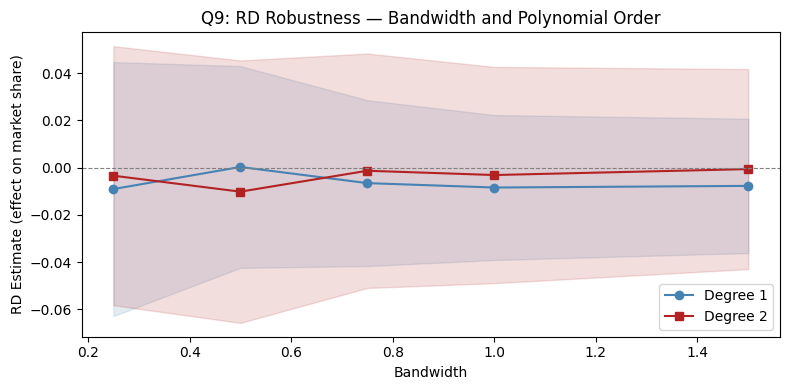

In [23]:
# Question 9

def rd_poly(df, outcome, running, cutoff, bw, degree=1):
    df_ = df.copy()
    df_['score_c'] = df_[running] - cutoff
    df_['above']   = (df_[running] >= cutoff).astype(int)
    within = df_[df_['score_c'].abs() <= bw].dropna(subset=[outcome])
    if within.shape[0] < 10:
        return np.nan, np.nan
    cols = ['above']
    for d in range(1, degree + 1):
        within[f'sc_{d}']       = within['score_c'] ** d
        within[f'sc_{d}_above'] = within[f'sc_{d}'] * within['above']
        cols += [f'sc_{d}', f'sc_{d}_above']
    X   = sm.add_constant(within[cols], has_constant='add')
    fit = sm.OLS(within[outcome], X).fit(cov_type='HC1')
    return float(fit.params['above']), float(fit.bse['above'])

rows9 = []
for bw in [0.25, 0.50, 0.75, 1.00, 1.50]:
    for deg in [1, 2]:
        est, se = rd_poly(rd_c, 'mkt_share', 'raw_score', CUTOFF, bw, degree=deg)
        rows9.append({
            'bandwidth'  : bw,
            'polynomial' : f'degree {deg}',
            'estimate'   : est,
            'se'         : se,
            'ci_lo'      : est - 1.96 * se if not np.isnan(se) else np.nan,
            'ci_hi'      : est + 1.96 * se if not np.isnan(se) else np.nan,
        })

sens_table = pd.DataFrame(rows9)

print('=== Q9: RD sensitivity — bandwidth and polynomial order ===\n')
print(sens_table.round(5).to_string(index=False))

fig, ax = plt.subplots(figsize=(8, 4))
for deg, color, marker in [(1, 'steelblue', 'o'), (2, 'firebrick', 's')]:
    sub = sens_table[sens_table['polynomial'] == f'degree {deg}'].dropna(subset=['estimate'])
    ax.plot(sub['bandwidth'], sub['estimate'],
            marker=marker, color=color, label=f'Degree {deg}', linewidth=1.5)
    ax.fill_between(sub['bandwidth'], sub['ci_lo'], sub['ci_hi'],
                    alpha=0.15, color=color)
ax.axhline(0, linestyle='--', color='grey', linewidth=0.8)
ax.set_xlabel('Bandwidth')
ax.set_ylabel('RD Estimate (effect on market share)')
ax.set_title('Q9: RD Robustness — Bandwidth and Polynomial Order')
ax.legend()
plt.tight_layout()
plt.show()

lin_ests  = sens_table.loc[sens_table['polynomial'] == 'degree 1', 'estimate'].dropna()
quad_ests = sens_table.loc[sens_table['polynomial'] == 'degree 2', 'estimate'].dropna()

In [24]:
# Question 10

q1_yr    = q1.set_index('year')
q6_base  = float(rd_table.loc[rd_table['bandwidth'] == 0.50, 'estimate'].iloc[0])
q6_se    = float(rd_table.loc[rd_table['bandwidth'] == 0.50, 'se'].iloc[0])
lin_bw05 = float(sens_table.loc[
    (sens_table['bandwidth'] == 0.5) & (sens_table['polynomial'] == 'degree 1'),
    'estimate'].iloc[0])

print('=' * 70)
print('HWK3 SUMMARY')
print('=' * 70)

print(f"""
Q1  Plan-county observations range from {q1_yr["n_plan_county_obs"].min():,} to
    {q1_yr["n_plan_county_obs"].max():,} per year with roughly 550-630 unique
    contracts. Average enrollment grows steadily as MA penetration increases.

Q2  Market share peaks at {peak_star} stars ({peak_share:.4f}) rather than at the
    highest rating, though average enrollment does rise with star rating.

Q3  The modal rating shifts from 2.5 in 2010 to 4.0 by 2015, with the share
    rated 3+ rising from {stats_by_yr[2010]["pct_above3"]:.1f}% to
    {stats_by_yr[2015]["pct_above3"]:.1f}%, driven by quality improvement and
    low-rated plan exit.

Q4  Plans rated above 2.5 stars generally have higher market share, with the
    3.0-star coefficient positive and highly significant. The relationship is
    non-monotonic at the top of the distribution.

Q5  The RD plot shows no dramatic visual jump in market share at the 2.75
    raw-score cutoff, with fitted lines close in level on both sides.

Q6  The local linear RD estimate at bandwidth 0.50 is {q6_base:+.4f}
    (SE = {q6_se:.4f}), which is not statistically significant at conventional
    levels.

Q7  The density test (p = {p_chi2:.3f}) and smooth histogram find no evidence
    of bunching at the cutoff, supporting RD validity.

Q8  All three pre-determined covariates are balanced at the cutoff (all p > 0.10),
    further supporting the identifying assumption.

Q9  Estimates are small and centered near zero across all bandwidth-polynomial
    combinations (linear range: {lin_ests.min():.4f} to {lin_ests.max():.4f}),
    confirming the null result in Q6 is not specification-dependent.

The data show clear quality improvement in the MA market between 2010 and 2015,
with higher-rated plans attracting more enrollment overall. However, the RD
analysis finds no statistically significant discontinuity in market share at the
3-star threshold in 2010, suggesting consumers and brokers had not yet fully
incorporated the new star-rating information into enrollment decisions in the
program's first year.
""")

HWK3 SUMMARY

Q1  Plan-county observations range from 62,333 to
    109,948 per year with roughly 550-630 unique
    contracts. Average enrollment grows steadily as MA penetration increases.

Q2  Market share peaks at 3.0 stars (0.0991) rather than at the
    highest rating, though average enrollment does rise with star rating.

Q3  The modal rating shifts from 2.5 in 2010 to 4.0 by 2015, with the share
    rated 3+ rising from 45.6% to
    99.0%, driven by quality improvement and
    low-rated plan exit.

Q4  Plans rated above 2.5 stars generally have higher market share, with the
    3.0-star coefficient positive and highly significant. The relationship is
    non-monotonic at the top of the distribution.

Q5  The RD plot shows no dramatic visual jump in market share at the 2.75
    raw-score cutoff, with fitted lines close in level on both sides.

Q6  The local linear RD estimate at bandwidth 0.50 is +0.0003
    (SE = 0.0218), which is not statistically significant at conventional
 